# Extra dependencies installation

In [2]:
!pip install vit-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Imports

In [3]:
import os
import torch
import torch
from torch import nn
from torchvision import datasets
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import psutil
import h5py
import os
import numpy as np
import time
import copy
from torchsummary import summary
from torch import optim
from torch.optim import lr_scheduler
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from vit_pytorch import ViT

# Setup dataset 

In [21]:
try:
  import google.colab
  COLAB_ENV = True
except:
  COLAB_ENV = False


if COLAB_ENV:
  start = "/" + os.path.join("content","drive","MyDrive","datasets")
  from google.colab import drive
  drive.mount('/content/drive')
else:
  start = "data"

data_filepath = os.path.join(start, "ML4SCI_GSOC23")
photon_file = "SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5"
electron_file = "SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5"

photon_filepath = os.path.join(data_filepath, photon_file)
electron_filepath = os.path.join(data_filepath, electron_file)

electronFile = h5py.File(electron_filepath, "r")
photonFile = h5py.File(photon_filepath, "r")

class PhotonElectronDataset(Dataset):
    def __init__(self, _electron_filepath, _photon_filepath, transform=None, target_transform=None, low = 0, high = 1, seed=1234):
        np.random.seed(seed)

        electronFile = h5py.File(_electron_filepath, "r")
        photonFile = h5py.File(_photon_filepath, "r")

        ElectronX, ElectronY = electronFile["X"], electronFile["y"]
        PhotonX, PhotonY = photonFile["X"], photonFile["y"]

        print(f"Electron label is : ", np.unique(ElectronY))
        print(f"Photon label is : ", np.unique(PhotonY))

        whole_dataset_size = ElectronX.shape[0]

        _low = int(low * whole_dataset_size)
        _high = int(high * whole_dataset_size)

        self.X = np.concatenate([ElectronX[_low:_high, :,:,:], PhotonX[_low:_high, :,:,:]])
        self.Y = np.concatenate([ElectronY[_low:_high], PhotonY[_low:_high]])
        self.transform = transform
        self.dataset_size = _high - _low + 1

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        #image = torch.from_numpy(self.X[idx, :, :, :])
        image = self.X[idx, :, :, :]

        label = self.Y[idx,]
        if self.transform:
            image = self.transform(image)
        return image, label

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# EDA 
- just inspect the images, validate whether the dataset is correct

In [61]:
batch_size = 16

training_dataset = PhotonElectronDataset(electron_filepath, photon_filepath, low=0, high = 0.8, transform=transforms.Compose([transforms.ToTensor()]))
validation_dataset  = PhotonElectronDataset(electron_filepath, photon_filepath, low=0.8, high=0.9,transform=transforms.Compose([transforms.ToTensor()]))
testing_dataset  = PhotonElectronDataset(electron_filepath, photon_filepath, low=0.9, high=1, transform=transforms.Compose([transforms.ToTensor()]))

print(f"training size : {len(training_dataset)}")
print(f"validation size : {len(validation_dataset)}")
print(f"testing size : {len(testing_dataset)}")

train_dataloader      = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
test_dataloader       = DataLoader(testing_dataset, batch_size=batch_size, shuffle=True)

Electron label is :  [1.]
Photon label is :  [0.]
Electron label is :  [1.]
Photon label is :  [0.]
Electron label is :  [1.]
Photon label is :  [0.]
training size : 398400
validation size : 49800
testing size : 49800


torch.Size([16, 2, 32, 32])


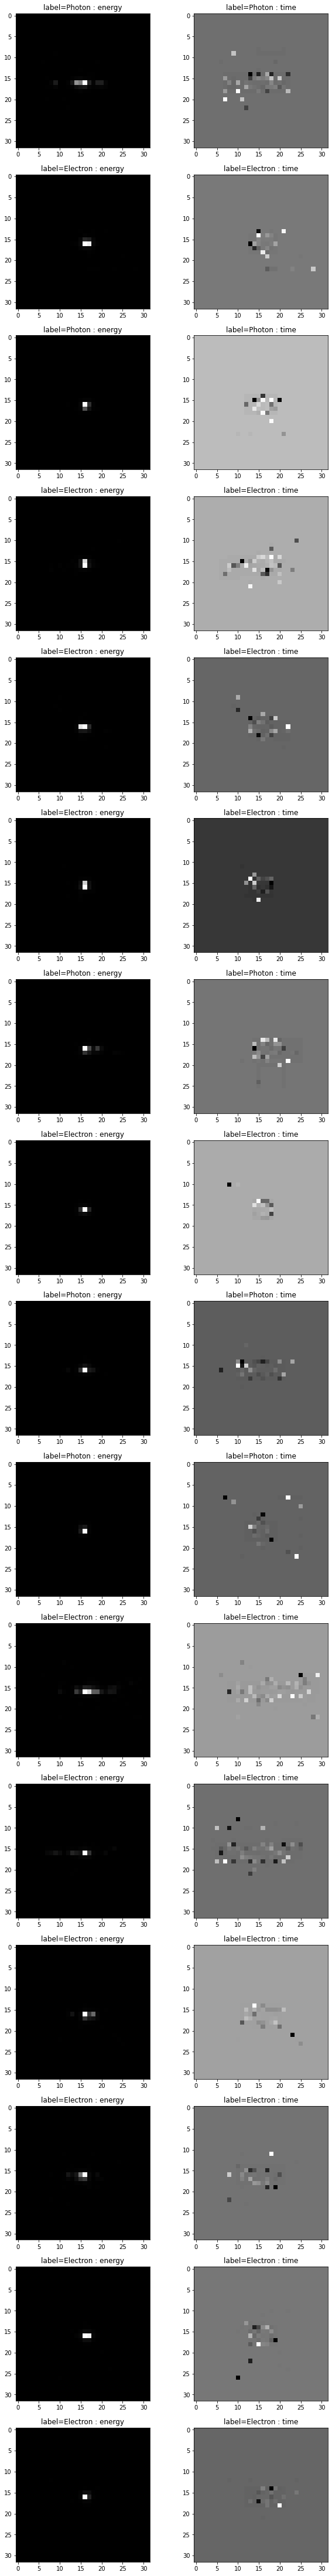

In [65]:
from math import sqrt

train_features, train_labels = next(iter(train_dataloader))
print(train_features.shape)
label_val_to_text = {1 : "Electron", 0 : "Photon"}

scale = 5
n = int(batch_size)
plt.figure(figsize=(2*scale , scale * n))

for y in range(n):
  plt.subplot(n,2, 2 * y + 1)
  label = label_val_to_text[train_labels[y].item()]
  plt.title(f"label={label} : energy")
  plt.imshow(train_features[y, 0, :, :], cmap='gray')

  plt.subplot(n, 2, 2 * y + 2)
  plt.title(f"label={label} : time")
  plt.imshow(train_features[y, 1, :, :], cmap='gray')


plt.show()

# Pytorch Util functions 

training function and setting up tensorboard for monitoring

In [93]:
import torch
from torch.utils.tensorboard import SummaryWriter

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device Used : {device}")

def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, saveTo, num_epochs=25):
    writer = SummaryWriter()
    since = time.time()

    returnDict = {"trainingLoss" : [], "validationLoss" : [], "trainingAccuracy" : [], "validationAccuracy" : [], 
                  "epochs" : [], "trainingAUC" : [], "validationAUC" : []}
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        returnDict["epochs"].append(epoch)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            since2 = time.time()
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            y = torch.Tensor()
            pred_y = torch.Tensor()

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                labels = labels.long()

                y = torch.cat([y, labels.cpu()])
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    probs, preds = torch.max(outputs, 1)

                    #print(outputs.shape)
                    loss = criterion(outputs, labels.reshape(-1, 1).to(torch.float32))

                    pred_y = torch.cat([pred_y, outputs[:, 0].cpu()])

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            AUC_ROC = roc_auc_score(y.detach().numpy(), pred_y.detach().numpy())  

            if phase == "train":
                returnDict["trainingLoss"].append(epoch_loss)
                returnDict["trainingAccuracy"].append(epoch_acc.cpu().item())
                returnDict["trainingAUC"].append(AUC_ROC)
                writer.add_scalar("Loss/train", epoch_loss, epoch)
                writer.add_scaler("Accuracy/train", epoch_acc.cpu().item(), epoch)
                writer.add_scalar("AUC/train", AUC_ROC, epoch)
            else:
                returnDict["validationLoss"].append(epoch_loss)
                returnDict["validationAccuracy"].append(epoch_acc.cpu().item())
                returnDict["validationAUC"].append(AUC_ROC)
                writer.add_scalar("Loss/validation", epoch_loss, epoch)
                writer.add_scaler("Accuracy/validation", epoch_acc.cpu().item(), epoch)
                writer.add_scalar("AUC/validation", AUC_ROC, epoch)


            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} AUC ROC : {AUC_ROC:.4f} Time taken : {round(time.time() - since2, 2)}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model, saveTo)

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    returnDict["best_model"] = model
    writer.close()
    return returnDict

Device Used : cpu


# Baseline

minimal simple architecture that provide some baseline accuracy

In [ ]:
import torch.nn.functional as F
from torch.nn import BCELoss
import torch.optim as pt_optim
import torch.optim.lr_scheduler as pt_lr_scheduler


class Simple(nn.Module):

    def __init__(self):
        super(Simple, self).__init__()
        self.conv1 = nn.Conv2d(2, 16, 5, padding=2)
        self.conv2 = nn.Conv2d(16, 16, 5)
        self.conv3 = nn.Conv2d(16, 32, 5)

        self.fc1   = nn.Linear(576, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 1)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = x.view(-1, np.prod(x.size()[1:]) )
        #print(x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

m = Simple().to(device)
optim = pt_optim.Adam(m.parameters(), 1e-5)
lr_sched = pt_lr_scheduler.StepLR(optim, 10, 0.9)
dataloaders = {
    "train" : train_dataloader,
    "val" : validation_dataloader
}

dataset_sizes = {
    "train" : len(training_dataset),
    "val" : len(validation_dataset)
}

train_model(m, F.binary_cross_entropy_with_logits, optim, lr_sched, dataloaders, dataset_sizes, "Simple.pt")

Epoch 0/24
----------
